In [1]:
import pandas as pd
import os, os.path
import h5py
import matplotlib
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy.io.idl import readsav
from astropy.io import fits
from matplotlib import rcParams, cycler
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from time import gmtime, strftime
from datetime import datetime
from tempfile import TemporaryFile
import os
from scipy.optimize import curve_fit
from matplotlib import gridspec

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [3]:
#from keras.layers import Flatten, Dense, Dropout, Input, Concatenate, LeakyReLU, BatchNormalization, MaxPooling1D, regularizers
#from keras.layers.core import Activation
#from keras.callbacks import EarlyStopping, TensorBoard
#from keras.layers.merge import concatenate
#from keras.utils.vis_utils import plot_model
#from keras.models import load_model
#from keras.optimizers import Adam
#from keras import backend as K
#from keras import initializers

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, concatenate, LeakyReLU, Convolution1D, MaxPooling1D, BatchNormalization, SpatialDropout1D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.manifold import TSNE

#from tensorflow.keras import Activations
#np.__version__, tf.__version__, keras.__version__

In [4]:
#import keras
#keras.__version__

In [5]:
from tensorflow.python.client import device_lib

def get_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

get_devices()

['/device:CPU:0']

In [6]:
#Normalize the labels

def normalize_labels(y, limits=None):
    if limits is None:
        limits = []
        for i in range(y.shape[1]):
            mn = min(y[:,i])
            mx = max(y[:,i])
            y[:,i] = (y[:,i] - mn) / (mx - mn)
            limits.append((mn,mx))
        return y, limits

    else:
        for i in range(y.shape[1]):
            y[:,i] = (y[:,i] - limits[i][0]) / (limits[i][1] - limits[i][0])
        return y

In [7]:
#Normalize the parameters

def normalize_parameters(X, limits=None):
    if limits is None:
        limits = []
        for i in range(X.shape[1]):
            mn = min(X[:,i,:])[0]
            mx = max(X[:,i,:])[0]
            X[:,i,:] = (X[:,i,:] - mn) / (mx - mn)
            limits.append((mn,mx))
        return X, limits

    else:
        for i in range(X.shape[1]):
            X[:,i,:] = (X[:,i,:] - limits[i][0]) / (limits[i][1] - limits[i][0])
        return X

In [8]:
def gaussian_nll(y_true, y_pred):
    n_dims = int(int(y_pred.shape[1])/2)
    mu = y_pred[:, 0:n_dims]
    logsigma = K.clip(y_pred[:, n_dims:],-7,7)

    mse = -0.5 * K.sum(K.square((y_true - mu) / K.exp(logsigma)), axis=1)   # exponential of logsigma
    sigma_trace = -K.sum(logsigma, axis=1)
    log2pi = -0.5 * n_dims * np.log(2 * np.pi)

    log_likelihood = mse + sigma_trace + log2pi

    return K.mean(-log_likelihood)

In [9]:
def load_data(filename_spectra, filename_parameters, filename_labels, validation_percent_split):

    #snr_data_frame = pd.read_csv('Vrad/gesiDR5_GIRAFFE_HR15_training_sample_with_phot_snr.csv')
    #snr_data_frame = pd.read_csv('Vrad/DR6_xmatch_Gaia_DR2_MADERA_snr.csv')
    #w_snr = (snr_data_frame.snr > snr_cut)

    #LOAD THE SPECTRA OF THE TRAINING SAMPLE
    ext = filename_spectra.split('.')[-1]
    if ext in ('fits', 'fts'):
        hdu = fits.open(filename_spectra)
        spectra_matrix = hdu[0].data.T
        hdu.close()
        #vrad = spectra_matrix['VRAD']
        #print(vrad)
    elif ext in ('csv',):
        spectra_matrix = np.loadtxt(filename_spectra)

    elif ext == 'npy':
        spectra_matrix = np.load(filename_spectra)

    n_rows_spectra, n_columns_spectra = spectra_matrix.shape

    data_matrix = spectra_matrix.reshape(n_rows_spectra, n_columns_spectra, 1)
    data_matrix = data_matrix.astype('float32')

    #LOAD EXTRA PARAMETERS FOR THE TRAINING
    if filename_parameters is not None:
        ext = filename_parameters.split('.')[-1]
        if ext in ('fits', 'fts'):
            hdu = fits.open(filename_parameters)
            parameters_matrix = pd.DataFrame(hdu[1].data).to_numpy()
            hdu.close()

        elif ext in ('csv',):
            parameter_frame   = pd.read_csv(filename_parameters)
            parameters_matrix = parameter_frame.values

        elif ext == 'npy':
            parameters_matrix = np.load(filename_parameters)

        n_rows_parameters, n_columns_parameters = parameters_matrix.shape

        parameters_matrix = parameters_matrix.reshape(n_rows_parameters, n_columns_parameters, 1)
        parameters_matrix = parameters_matrix.astype('float32')

        assert n_rows_spectra == n_rows_parameters, 'Data and parameter files have different length'

        data_matrix = np.concatenate((data_matrix, parameters_matrix), axis=1)

    #LOAD LABELS AND ERRORS
    if filename_labels is not None:

        ext = filename_labels.split('.')[-1]
        if ext in ('fits', 'fts'):
            hdu = fits.open(filename_labels)
            label_matrix = hdu[0].data
            #print(temp_matrix.shape)
            #label_matrix = temp_matrix[(temp_matrix <150)&(temp_matrix>-100)]
            #print(label_matrix.shape)
            hdu.close()
        elif ext in ('csv',):
            label_frame = pd.read_csv(filename_labels)
            label_names = list(label_frame.columns)
            label_matrix = label_frame.values
        elif ext == 'npy':
            label_matrix = np.load(filename_labels)

        n_rows_labels, n_labels = label_matrix.shape

        assert n_rows_spectra == n_rows_labels

        label_matrix[:,1:] = label_matrix[:,1:].astype('float32')

        if validation_percent_split > 0:
            X_train, X_test, y_train, y_test = train_test_split(data_matrix, label_matrix, test_size= validation_percent_split / 100.0, random_state=42)    #split the data, creating a test sample of X%
            
            y_train_IDs   = y_train[:,:1]                 # you have to apply the conditon here too
            y_test_IDs    = y_test[:,:1]                 # you have to apply the conditon here too
            y_train       = y_train[:,1:]                 # you have to apply the conditon here too
            y_test        = y_test[:,1:]                 # you have to apply the conditon here too
            
            condition_train = (y_train>-200)&(y_train<200)             #(y_train>-100)&(y_train<150)
            condition_test  = (y_test>-200)&(y_test<200)                   #(y_test>-100)&(y_test<150)
            print(condition_train.shape)
            condition_train = np.reshape(condition_train, len(condition_train))
            condition_test = np.reshape(condition_test, len(condition_test))
            print(condition_train.shape)
            
            y_train_IDs   = y_train_IDs[condition_train,:1]                 # you have to apply the conditon here too
            y_test_IDs    = y_test_IDs[condition_test,:1]                 # you have to apply the conditon here too
            y_train = y_train[condition_train] #y_train[(y_train>-100)&(y_train<150)]        ## restricting Vrad to be in between -100 and 150 Km/s   ## not sure if we need this anymore
            y_test = y_test[condition_test]
        
            y_train= np.reshape(y_train,(len(y_train),1))
            y_test = np.reshape(y_test,(len(y_test),1))

            
            X_train_spec  = X_train[condition_train,:n_columns_spectra,:]      #       X_train_spec  = X_train[condition_train,:n_columns_spectra,:]  ???
            X_train_param = X_train[condition_train,n_columns_spectra:,:]                 # you have to apply the conditon here too
            X_test_spec   = X_test[condition_test,:n_columns_spectra,:]      #       X_test_spec  = X_test[condition_test,:n_columns_spectra,:]  ???
            X_test_param  = X_test[condition_test,n_columns_spectra:,:]                 # you have to apply the conditon here too

            

            if X_train_param.shape[1] == 0: X_train_param = None
            if X_test_param.shape[1]  == 0: X_test_param  = None

            return X_train_spec, X_train_param, y_train, X_test_spec, X_test_param, y_test, label_names, y_train_IDs, y_test_IDs

        else:
            X_train, y_train = data_matrix, label_matrix
            if filename_parameters is not None:
                X_train_spec  = X_train[:,:n_columns_spectra,:]
                X_train_param = X_train[:,n_columns_spectra:,:]
            else: 
                X_train_spec = X_train
                X_train_param = None
                y_train_IDs   = y_train[:,:1]
                y_train       = y_train[:,1:]
            return X_train_spec, X_train_param, y_train, None, None, None, label_names, None, y_train_IDs

    else:
        if filename_parameters is not None:
            X_train_spec  = data_matrix[:,:n_columns_spectra,:]
            X_train_param = data_matrix[:,n_columns_spectra:,:]
        else: 
            X_train_spec = data_matrix
            X_train_param = None
        return X_train_spec, X_train_param, None, None, None, None, None, None, None

### ARCHITECTURE OF THE NEURAL NETWORK

In [10]:
def architecture(iptdim, use_param, use_nll): ## iptdim_mag should be provided if parameters are used

    ipt       = Input(shape=(iptdim, 1))
    #ipt_param = Input(shape=(iptdim_mag,1))

    #x = Convolution1D(16, kernel_size=5, kernel_regularizer=regularizers.l2(0.005), padding='valid', name = 'convol_1')(ipt)#,kernel_regularizer=regularizers.l2(0.005)
    #x = LeakyReLU()(x)
    x = Convolution1D(8, kernel_size=5, kernel_regularizer=regularizers.l2(0.005), padding='valid', name = 'convol_1')(ipt)#, kernel_regularizer=regularizers.l2(0.005)
    x = LeakyReLU()(x)
    x = Convolution1D(4, kernel_size=5, kernel_regularizer=regularizers.l2(0.005), padding='valid', name = 'convol_2')(x)
    x = LeakyReLU()(x)
    x = Convolution1D(2, kernel_size=5, kernel_regularizer=regularizers.l2(0.005), padding='valid', name = 'convol_3')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.10)(x)

    x = Flatten()(x)
    x = Dense(32)(x)
    x = LeakyReLU()(x)

    if(use_param==True):                            # GG: this is where the photometry is added into the neural-network
        y = Flatten()(ipt_param)
        y = Dense(32)(y)
        y = LeakyReLU()(y)
        y = Dense(16)(y)
        y = LeakyReLU()(y)
        x = concatenate([x, y])

    x = Dense(32)(x)
    x = LeakyReLU()(x)
    x = Dense(16)(x)
    x = LeakyReLU()(x)
    #x = Dense(16)(x)
    #x = LeakyReLU()(x)


    ipt_all = [ipt]
    if(use_param==True):
        ipt_all = [ipt, ipt_param]

    if(use_nll == False):
        cnnout = Dense(y_train.shape[1], activation='linear')(x)
    if(use_nll == True):
        cnnout = Dense(y_train.shape[1]*2, activation='linear')(x)
    cnn = Model(ipt_all, cnnout)

    return cnn

### INITIAL CONDITIONS

In [11]:
validation_percent_split = 20
patience_n               = 30
n_epoch_max              = 1000 #1000
n_run                    = 10
batch_siz                = 128
use_param                = False     # GG: here, True should be used if you use photometry and parallaxes.
v                        = "1"
flag_phot                = str(use_param)
lr                       = 0.00005   #0.00005 try this value of lr
optimizer                = Adam(lr)
use_nll                  = False

### OBSERVED SAMPLE

In [12]:
#loading observations
filename_spectra_obs    = 'Data/large_observerd_sample_uncorrected_spectra_SN_0-50.fits'
filename_parameters_obs = None #'Data/gaia_photometry_observed.csv' #'Data/GES_iDR6_WG15_Recommended_parameters.fits'

X_obs_spec, X_obs_param,_,_,_,_,_,_,_ = load_data(filename_spectra_obs, filename_parameters_obs,None,None)

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =",current_time)
print(X_obs_spec.shape)

Current Time = 07:49:56
(317340, 913, 1)


### LOAD TRAINING SAMPLE, CUT TEST SAMPLE, COMPUTE ABSOLUTE MAGNITUDES, RUN N TIMES THE NEURAL NETWORK

In [13]:
#labelss = pd.read_csv('Data/label_Vrad.csv')
#labelss
#all_labels = pd.read_csv('Data/gesiDR6_GIRAFFE_HR15_training_sample_with_phot_2_for_G.csv')

#hdu = fits.open('Data/spectra_GIRAFFE_HR15_dr6_2_training_for_G.fits')
#spectra_matrix = hdu[0].data.T
#hdu.close()
#tsne_all = TSNE(n_components=2).fit_transform(spectra_matrix)
#df=pd.DataFrame({'aaa' : tsne_all[:, 0], 'bbb' : tsne_all[:, 1], 'vrad' : labelss.VRAD_2})
#df.plot.scatter('aaa','bbb',c='vrad',s=2.0,colormap='rainbow', vmin=-100.0,vmax=100.0)#, rasterized=True)

In [14]:
snr_cut = 0.0

filename_spectra        = 'Data/large_training_sample_uncorrected_spectra_vrad_-200_200_SN_>50.fits'
filename_labels         = 'Data/labels_large_training_sample_uncorrected_spectra_vrad_-200_200_SN_>50.csv'
filename_parameters     = None #'Data/gaia_photometry_train.csv' #'Data/GES_iDR6_WG15_Recommended_parameters.fits'

X_train_spec, X_train_param, y_train_all, X_test_spec, X_test_param, y_test_all, label_names, y_train_IDs, y_test_IDs = load_data(filename_spectra, filename_parameters, filename_labels, validation_percent_split)

#hist of y_train_all

############################################ Normalization #########################################
y_train, limits_labels = normalize_labels(y_train_all + 0.0)
y_test = normalize_labels(y_test_all + 0.0, limits_labels)
####################################################################################################

#GG: here you normalize the X_train_param, X_test_param, X_obs_param
# X_train_mag, limits_mag_params = normalize_parameters(X_train_param + 0.0)
# X_test_mag = normalize_parameters(X_test_param + 0.0, limits_mag_params)
# X_obs_mag  = normalize_parameters(X_obs_param + 0.0, limits_mag_params)


X_train_spec = np.asarray(X_train_spec).astype(np.float32) #put the arrays in the proper type
X_test_spec  = np.asarray(X_test_spec).astype(np.float32)
X_obs_spec   = np.asarray(X_obs_spec).astype(np.float32)
y_train      = np.asarray(y_train).astype(np.float32)
y_test       = np.asarray(y_test).astype(np.float32)

#GG: put the magnitudes into the proper type
# X_train_mag  = np.asarray(X_train_mag).astype(np.float32)
# X_test_mag   = np.asarray(X_test_mag).astype(np.float32)
# X_obs_mag    = np.asarray(X_obs_mag).astype(np.float32)

#GG: prints the shape of the mags
if(use_param == True):
    print(X_train_param.shape)
    print(X_test_param.shape)
    print(X_obs_mag.shape)


print(X_train_spec.shape, type(X_train_spec))
print(X_test_spec.shape,  type(X_test_spec))
print(y_train.shape,      type(y_train))
print(y_test.shape,       type(y_test))

#print(X_obs_spec.shape,   type(X_obs_spec))


(89681, 1)
(89681,)


(89681, 913, 1) <class 'numpy.ndarray'>
(22421, 913, 1) <class 'numpy.ndarray'>
(89681, 1) <class 'numpy.ndarray'>
(22421, 1) <class 'numpy.ndarray'>


In [15]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience_n, verbose=1, mode='auto')    #function that tells you when the training process should stop

iptdim     = len(X_train_spec[0])
#iptdim_mag = len(X_train_mag[0]) #GG: this give the input shape for the CNN when using the mags

cnn = architecture(iptdim, use_param, use_nll)
cnn.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 913, 1)]          0         
_________________________________________________________________
convol_1 (Conv1D)            (None, 909, 8)            48        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 909, 8)            0         
_________________________________________________________________
convol_2 (Conv1D)            (None, 905, 4)            164       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 905, 4)            0         
_________________________________________________________________
convol_3 (Conv1D)            (None, 901, 2)            42        
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 901, 2)            0     

In [16]:
histories = []   #history is the log file of the training

now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =",current_time)

#SAVE THE DATA AND THE LIMITS
np.savez('data_models/vrad_smat.npz', X_train_spec_tmp=X_train_spec, y_train_tmp=y_train, X_test_spec_tmp=X_test_spec, y_test_tmp=y_test,  label_names_tmp=label_names, limits_labels_tmp=limits_labels) ## X_train_mag_tmp = X_train_mag, X_test_mag_tmp = X_test_mag, should be used when using parameters

#begin of the N iterations:
for index_run in range(n_run):

    cnn = architecture(iptdim, use_param, use_nll)
    if(use_nll == False):
        cnn.compile(loss="mse", optimizer=optimizer, metrics=['mse'])
    if(use_nll == True):
        cnn.compile(loss=gaussian_nll, optimizer=optimizer) #mean_squared_logarithmic_error   #gaussian_nll    #metric = accuracy

    if(use_param==False):
        history = cnn.fit([X_train_spec], y_train, batch_size=batch_siz, epochs=n_epoch_max, validation_data=([X_test_spec], y_test), verbose=0, callbacks=[early_stop])
    if(use_param==True):   #GG: you see that when using use_param = True, you include the mags when fitting the model
        history = cnn.fit([X_train_spec,X_train_mag], y_train, batch_size=batch_siz, epochs=n_epoch_max, validation_data=([X_test_spec, X_test_mag], y_test), verbose=0, callbacks=[early_stop])
    histories.append(history)
    #SAVE THE CNN MODEL
    cnn.save('cnn_models/vrad_my_model_%03d' % index_run)  # creates a HDF5 file

    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    print("Current Time =",current_time)
    print(index_run)

#SAVE THE CNN HISTORY
np.savez('data_models/histories.npz', history= pd.DataFrame.from_dict(h.history for h in histories))#, allow_pickle=True)

Current Time = 07:50:03


Epoch 00160: early stopping


INFO:tensorflow:Assets written to: cnn_models/vrad_my_model_000/assets


Current Time = 08:12:25
0


Epoch 00301: early stopping


INFO:tensorflow:Assets written to: cnn_models/vrad_my_model_001/assets


Current Time = 08:54:34
1


Epoch 00241: early stopping


INFO:tensorflow:Assets written to: cnn_models/vrad_my_model_002/assets


Current Time = 09:28:13
2


Epoch 00265: early stopping


INFO:tensorflow:Assets written to: cnn_models/vrad_my_model_003/assets


Current Time = 10:05:24
3


Epoch 00218: early stopping


INFO:tensorflow:Assets written to: cnn_models/vrad_my_model_004/assets


Current Time = 10:35:53
4


Epoch 00204: early stopping


INFO:tensorflow:Assets written to: cnn_models/vrad_my_model_005/assets


Current Time = 11:04:32
5


Epoch 00246: early stopping


INFO:tensorflow:Assets written to: cnn_models/vrad_my_model_006/assets


Current Time = 11:38:56
6


Epoch 00293: early stopping


INFO:tensorflow:Assets written to: cnn_models/vrad_my_model_007/assets


Current Time = 12:20:06
7


Epoch 00535: early stopping


INFO:tensorflow:Assets written to: cnn_models/vrad_my_model_008/assets


Current Time = 13:35:31
8


Epoch 00242: early stopping


INFO:tensorflow:Assets written to: cnn_models/vrad_my_model_009/assets


Current Time = 14:09:31
9


In [17]:
run = 'run_21_mse' ## to save plots for different runs
parent_dir = "plots/"
path = os.path.join(parent_dir, run)
os.mkdir(path, mode=0o777)

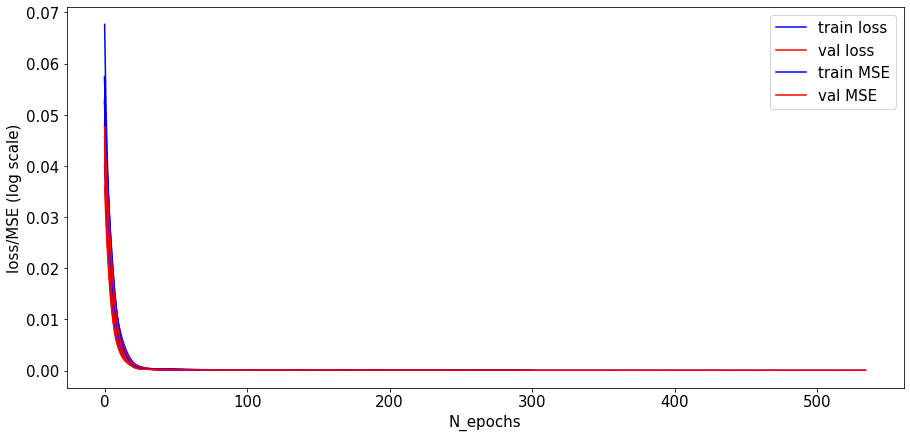

In [18]:
plt.rcParams.update({'font.size': 15})
fig=plt.figure(figsize=(15,7))
ax=fig.add_subplot(1,1,1)
for h in histories:
    plt.plot(h.history['loss'], c='blue')
    plt.plot(h.history['val_loss'], c='red')
    #plt.plot(h.history['mse'], c='green')
    #plt.plot(h.history['val_mse'], c='orange')
    #plt.yscale('log')
    plt.xlabel("N_epochs")
    plt.ylabel("loss/MSE (log scale)")
    plt.legend(['train loss','val loss', 'train MSE', 'val MSE'])
plt.savefig("plots/"+run+"/loss_over_MSE.png", bbox_inches='tight')


### CREATE MEAN AND DISPERSION OF THE N RUNS RESULTS

In [19]:
X_test_spec.shape

(22421, 913, 1)

In [20]:
X_train_spec.shape

(89681, 913, 1)

In [21]:
X_obs_spec.shape

(317340, 913, 1)

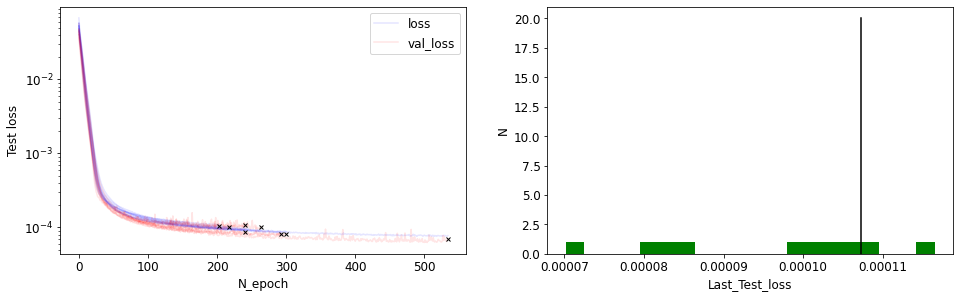

In [22]:
last_val_loss = np.array([h.history['val_loss'][-1] for h in histories])
last_epoch    = np.array([len(h.history['val_loss'])-1 for h in histories])
percenti = np.percentile(last_val_loss, 80.0)
index_good_training = np.array(np.where(last_val_loss < percenti)[0])

plt.rcParams.update({'font.size': 12})
fig=plt.figure(figsize=(16,10))
ax=fig.add_subplot(2,2,1)
for h in histories:
    plt.plot(h.history['loss'],     c='b', alpha=0.1)
    plt.plot(h.history['val_loss'], c='r', alpha=0.1)
    plt.yscale('log')
    plt.xlabel("N_epoch")
    plt.ylabel("Test loss")
    plt.legend(['loss','val_loss'])
plt.plot(last_epoch[index_good_training], last_val_loss[index_good_training],'x', color = 'black', markersize=4.0)
    
ax=fig.add_subplot(2,2,2)
plt.hist(last_val_loss, bins = 20, histtype = 'stepfilled', facecolor = 'green')
plt.plot([percenti, percenti], [0.0, +20.0], c = 'black')
plt.xlabel("Last_Test_loss")
plt.ylabel("N")
plt.savefig("plots/"+run+"/val_loss.png", bbox_inches='tight')


In [23]:
#Add together the n_runs
if(use_nll == False):
    res_train_all = np.zeros((len(index_good_training),len(y_train),   y_train.shape[1]))
    res_test_all  = np.zeros((len(index_good_training),len(y_test),    y_train.shape[1]))
    res_obs_all   = np.zeros((len(index_good_training),len(X_obs_spec), y_train.shape[1]))
if(use_nll == True):
    res_train_all = np.zeros((len(index_good_training),len(y_train),   y_train.shape[1]*2))
    res_test_all  = np.zeros((len(index_good_training),len(y_test),    y_train.shape[1]*2))
    res_obs_all   = np.zeros((len(index_good_training),len(X_obs_spec), y_train.shape[1]*2))
arr_tmp_test  = []   #np.zeros((len(index_good_training), y_test.shape[1],  X_test_spec.shape[1]))

data = np.load('data_models/vrad_smat.npz', allow_pickle=True)
y_test_i  = data['y_test_tmp']
y_train_i = data['y_train_tmp']

for idx, index_run in enumerate(index_good_training):

    print('cnn_models/vrad_my_model_%03d' % index_run)
    cnn = load_model('cnn_models/vrad_my_model_%03d' % index_run, custom_objects={'gaussian_nll': gaussian_nll})#
    if(use_param==False):
        res_train = cnn.predict([data['X_train_spec_tmp']])
        res_test  = cnn.predict([data['X_test_spec_tmp']])
        res_obs   = cnn.predict([X_obs_spec])
    if(use_param==True):     #GG: here as well, mags are used during the prediction
        res_train = cnn.predict([data['X_train_spec_tmp'],data['X_train_mag_tmp']])
        res_test  = cnn.predict([data['X_test_spec_tmp'],data['X_test_mag_tmp']])
        res_obs   = cnn.predict([X_obs_spec,X_obs_mag])
    #back to real units
    if(use_nll == False):
        array_limits_labels = np.asarray(data['limits_labels_tmp'])
        for kk in range(y_train_i.shape[1]):
            corr = (array_limits_labels[kk,1] - array_limits_labels[kk,0])
            res_train_all[idx,:,kk] = res_train[:,kk] * corr + array_limits_labels[kk,0]
            res_test_all[idx,:,kk]  = res_test[:,kk]  * corr + array_limits_labels[kk,0]
            res_obs_all[idx,:,kk]   = res_obs[:,kk]   * corr + array_limits_labels[kk,0]

    if(use_nll == True):

        array_limits_labels = np.concatenate((data['limits_labels_tmp'],data['limits_labels_tmp']),axis=0)
        res_train[:,range(y_train.shape[1],y_train.shape[1]*2)] = np.exp(res_train[:,range(y_train.shape[1],y_train.shape[1]*2)])
        res_test[:,range(y_train.shape[1],y_train.shape[1]*2)]  = np.exp(res_test[:,range(y_train.shape[1],y_train.shape[1]*2)])
        res_obs[:,range(y_train.shape[1],y_train.shape[1]*2)]   = np.exp(res_obs[:,range(y_train.shape[1],y_train.shape[1]*2)])

        cof = 1.0
        for kk in range(y_train_i.shape[1]*2):
            corr = (array_limits_labels[kk,1] - array_limits_labels[kk,0])
            if(kk>=y_train_i.shape[1]):
                cof = 0.0
            res_train_all[idx,:,kk] = res_train[:,kk] * corr + cof * array_limits_labels[kk,0]
            res_test_all[idx,:,kk]  = res_test[:,kk]  * corr + cof * array_limits_labels[kk,0]
            res_obs_all[idx,:,kk]   = res_obs[:,kk]   * corr + cof * array_limits_labels[kk,0]

    #GRADIENTS
    eg = []
    spec = tf.Variable(X_train_spec[:100,:,:], dtype=np.float32)
    ytes = tf.Variable(y_train[:100,:], dtype=np.float32)
    #ptes = tf.Variable(X_train_mag[:100,:], dtype=np.float32)    #GG: I added here the mags
    
    for i in range(y_train.shape[1]):
        with tf.GradientTape() as tape:
            tape.watch(spec)
            if(use_param==False): prediction = cnn([spec] , training=False)               #GG: and here as well !
            if(use_param==True): prediction = cnn([spec,ptes] , training=False)
            loss = tf.keras.losses.mse(ytes, prediction[:,i:i+1])
            grad = tape.gradient(prediction[:,i:i+1], spec)
            eg.append(grad)
    arr1 = np.array(eg)
    print(arr1.shape)
    arr_tmp_test.append(arr1)

    del eg, spec, loss, grad, arr1, prediction

    print(idx, index_run)

arr_tmp_train = np.array(arr_tmp_test)


now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =",current_time)

cnn_models/vrad_my_model_001


(1, 100, 913, 1)
0 1
cnn_models/vrad_my_model_002


(1, 100, 913, 1)
1 2
cnn_models/vrad_my_model_003


(1, 100, 913, 1)
2 3
cnn_models/vrad_my_model_004


(1, 100, 913, 1)
3 4
cnn_models/vrad_my_model_005


(1, 100, 913, 1)
4 5
cnn_models/vrad_my_model_007


(1, 100, 913, 1)
5 7
cnn_models/vrad_my_model_008


(1, 100, 913, 1)
6 8
cnn_models/vrad_my_model_009


(1, 100, 913, 1)
7 9
Current Time = 14:15:05


In [24]:
final_eg_test     = np.mean(arr_tmp_train, axis = 0)     #estimated average gradient

y_train = y_train_all + 0.0
y_test = y_test_all + 0.0

if(use_nll == False):

    final_res_train = np.mean(res_train_all, axis = 0)     #estimated labels of the training sample
    final_res_test  = np.mean(res_test_all,  axis = 0)     #estimated labels of the test sample
    final_res_obs   = np.mean(res_obs_all,   axis = 0)

    final_disp_train = np.std(res_train_all, axis = 0)
    final_disp_test  = np.std(res_test_all,  axis = 0)
    final_disp_obs   = np.std(res_obs_all,   axis = 0)

    final_nll_train = final_disp_train + 0.0
    final_nll_test  = final_disp_test + 0.0
    final_nll_obs   = final_disp_obs + 0.0

    final_disp_of_nll_train = final_nll_train + 0.0
    final_disp_of_nll_test  = final_nll_test + 0.0
    final_disp_of_nll_obs   = final_nll_obs + 0.0

if(use_nll == True):

    final_res_train = np.mean(res_train_all[:,:,range(y_train_i.shape[1])], axis = 0)                     #estimate the mean final parameters
    final_res_test  = np.mean(res_test_all[:,:,range(y_train_i.shape[1])],  axis = 0)
    final_res_obs   = np.mean(res_obs_all[:,:,range(y_train_i.shape[1])],   axis = 0)

    final_disp_train = np.std(res_train_all[:,:,range(y_train_i.shape[1])], axis = 0)                     #estimate the mean final dispersion
    final_disp_test  = np.std(res_test_all[:,:,range(y_train_i.shape[1])],  axis = 0)
    final_disp_obs   = np.std(res_obs_all[:,:,range(y_train_i.shape[1])],   axis = 0)

    final_nll_train = np.mean(res_train_all[:,:,range(y_train_i.shape[1],y_train_i.shape[1]*2)], axis = 0)                     #estimate the mean final nll error
    final_nll_test  = np.mean(res_test_all[:,:,range(y_train_i.shape[1],y_train_i.shape[1]*2)],  axis = 0)
    final_nll_obs   = np.mean(res_obs_all[:,:,range(y_train_i.shape[1],y_train_i.shape[1]*2)],   axis = 0)

    final_disp_of_nll_train = np.std(res_train_all[:,:,range(y_train_i.shape[1],y_train_i.shape[1]*2)], axis = 0)                     #estimate the mean final nll error
    final_disp_of_nll_test  = np.std(res_test_all[:,:,range(y_train_i.shape[1],y_train_i.shape[1]*2)],  axis = 0)
    final_disp_of_nll_obs   = np.std(res_obs_all[:,:,range(y_train_i.shape[1],y_train_i.shape[1]*2)],   axis = 0)


In [26]:
Vrad_min_train = min(final_res_train)
Vrad_max_train = max(final_res_train)

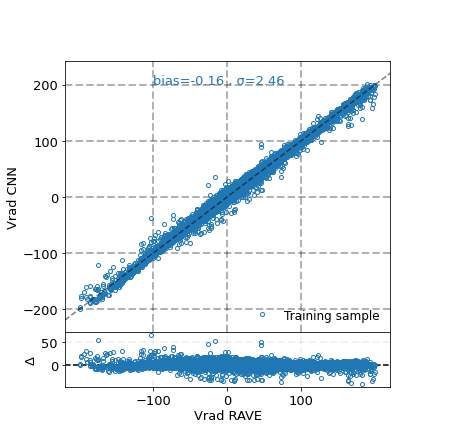

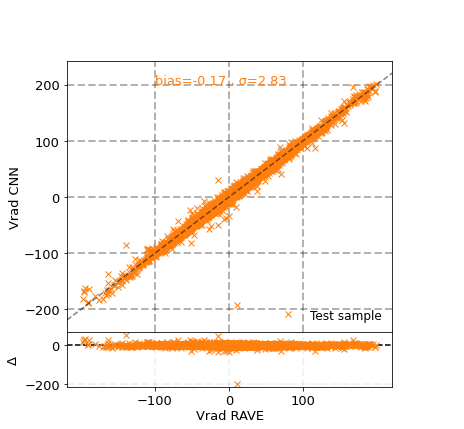

In [27]:
plt.rcParams.update({'font.size': 13})
ct=0

xlab       = ["Vrad"]#, ["Teff (K)"], "log(g)", "[Fe/H]"]

xmin_histo = [-500.0]#, 3000.0,     +0.0,     -2.5]
xmax_histo = [+500.0]#, 7000.0,     +5.5,     +1.0]
bin_histo  = [5.0]#,    150.0,      0.2,      0.08]
xmine      = [Vrad_min_train-20]#, 3800.0,     +0.2,     -2.5]
xmaxe      = [Vrad_max_train+20]#, 6900.0,     +5.1,     +1.0]
ymine      = [-50.0]#,  -450.0,     -0.5,     -0.5]
ymaxe      = [+50.0]#,  +450.0,     +0.5,     +0.5]
x_disp     = [-100.0]#, 3900.0,     0.5,      -2.3]
y_disp     = [200.0]#,  6700.0,     4.5,      +0.3]
corr       = [50]#,     400.0,      0.5,      0.3]


for xl in xlab:
    arond=2
    ct=ct+1
    fig = plt.figure(figsize=(7,7))
    gs = gridspec.GridSpec(3, 2, height_ratios=[0.2,1.0,0.2], width_ratios=[1.0,0.2]) #(line, column)

    ax3 = plt.subplot(gs[0,0])
    ax3.grid(color='black', linestyle='--', linewidth=2, alpha=0.30)
    #ax3.hist(y_train[:,ct-1], bins=(np.arange(xmin_histo[ct-1], xmax_histo[ct-1], bin_histo[ct-1])), log=True)
    #ax3.hist(y_test[:,ct-1],  bins=(np.arange(xmin_histo[ct-1], xmax_histo[ct-1], bin_histo[ct-1])), log=True)
    ax3.set_xlim(xmine[ct-1], xmaxe[ct-1])
    plt.axis('off')

    ax0 = plt.subplot(gs[1,0], sharex = ax3)
    plt.grid(color='black', linestyle='--', linewidth=2, alpha=0.30)
    ax0.plot(y_train[:,ct-1], final_res_train[:,ct-1], 'o', markersize=4.0, color='#1f77b4', fillstyle='none')
    #ax0.plot(y_test[:,ct-1],  final_res_test[:,ct-1],  'x', markersize=6.0, color='#ff7f0e')
    #ax0.set_xlim(xmine[ct-1], xmaxe[ct-1])
    #ax0.set_ylim(xmine[ct-1], xmaxe[ct-1])
    ax0.set_ylabel(xlab[ct-1] + " CNN",labelpad=2)
    #ax0.set_xticks([-200, -100, 0, 100, 200])
    #ax0.set_yticks([-200, -100, 0, 100, 200])
    if(ct==1): 
        plt.legend(["Training sample"], loc='lower right', frameon=False, prop={'size': 12})
    ax0.plot([xmine[ct-1], xmaxe[ct-1]], [xmine[ct-1], xmaxe[ct-1]],linestyle='--',color='black', alpha=0.5)
    ax0.text(x_disp[ct-1], y_disp[ct-1],           "bias="+str(round(np.mean(final_res_train[:,ct-1]-y_train[:,ct-1]),arond)) +" , \u03C3="+str(round(np.std(final_res_train[:,ct-1]-y_train[:,ct-1]),arond)),color='#1f77b4')
    #ax0.text(x_disp[ct-1], y_disp[ct-1]-corr[ct-1],"bias="+str(round(np.mean(final_res_test[:,ct-1] -y_test[:,ct-1]),arond))  +" , \u03C3="+str(round(np.std(final_res_test[:,ct-1] -y_test[:,ct-1]), arond)), color='#ff7f0e')

    ax1 = plt.subplot(gs[1,1], sharey = ax0)
    ax1.grid(color='black', linestyle='--', linewidth=2, alpha=0.05)
    #ax1.hist(final_res_train[:,ct-1], bins=(np.arange(xmin_histo[ct-1], xmax_histo[ct-1], bin_histo[ct-1])), log=True, orientation='horizontal')
    #ax1.hist(final_res_test[:,ct-1],  bins=(np.arange(xmin_histo[ct-1], xmax_histo[ct-1], bin_histo[ct-1])), log=True, orientation='horizontal')
    plt.subplots_adjust(wspace=.0)
    plt.axis('off')

    ax2 = plt.subplot(gs[2,0], sharex = ax0)
    ax2.grid(color='black', linestyle='--', linewidth=2, alpha=0.05)
    ax2.plot([xmine[ct-1], xmaxe[ct-1]], [0.0, 0.0],linestyle='--',color='black')
    ax2.plot(y_train[:,ct-1], final_res_train[:,ct-1] - y_train[:,ct-1], 'o', markersize=4.0, color='#1f77b4', fillstyle='none')
    #ax2.plot(y_test[:,ct-1], final_res_test[:,ct-1]  - y_test[:,ct-1],  'x', markersize=6.0, color='#ff7f0e')
    #ax2.set_xlim(xmine[ct-1], xmaxe[ct-1])
    #ax2.set_ylim(ymine[ct-1], ymaxe[ct-1])
    ax2.set_ylabel("\u0394")
    plt.subplots_adjust(hspace=.0)
    ax2.set_xlabel(xlab[ct-1] + " RAVE",labelpad=2)
    ax2.set_xticks([-100, 0, 100])
plt.savefig("plots/"+run+"/vrad_cnn_train.png", bbox_inches='tight')
ct=0
for xl in xlab:
    arond=2
    ct=ct+1
    fig = plt.figure(figsize=(7,7))
    gs = gridspec.GridSpec(3, 2, height_ratios=[0.2,1.0,0.2], width_ratios=[1.0,0.2]) #(line, column)

    ax3 = plt.subplot(gs[0,0])
    ax3.grid(color='black', linestyle='--', linewidth=2, alpha=0.30)
    #ax3.hist(y_train[:,ct-1], bins=(np.arange(xmin_histo[ct-1], xmax_histo[ct-1], bin_histo[ct-1])), log=True)
    #ax3.hist(y_test[:,ct-1],  bins=(np.arange(xmin_histo[ct-1], xmax_histo[ct-1], bin_histo[ct-1])), log=True)
    ax3.set_xlim(xmine[ct-1], xmaxe[ct-1])
    plt.axis('off')

    ax0 = plt.subplot(gs[1,0], sharex = ax3)
    plt.grid(color='black', linestyle='--', linewidth=2, alpha=0.30)
    #ax0.plot(y_train[:,ct-1], final_res_train[:,ct-1], 'o', markersize=4.0, color='#1f77b4', fillstyle='none')
    ax0.plot(y_test[:,ct-1],  final_res_test[:,ct-1],  'x', markersize=6.0, color='#ff7f0e')
    #ax0.set_xlim(xmine[ct-1], xmaxe[ct-1])
    #ax0.set_ylim(xmine[ct-1], xmaxe[ct-1])
    ax0.set_ylabel(xlab[ct-1] + " CNN",labelpad=2)
    #ax0.set_xticks([-200, -100, 0, 100, 200])
    #ax0.set_yticks([-200, -100, 0, 100, 200])
    if(ct==1): 
        plt.legend(["Test sample"], loc='lower right', frameon=False, prop={'size': 12})
    ax0.plot([xmine[ct-1], xmaxe[ct-1]], [xmine[ct-1], xmaxe[ct-1]],linestyle='--',color='black', alpha=0.5)
    #ax0.text(x_disp[ct-1], y_disp[ct-1],           "bias="+str(round(np.mean(final_res_train[:,ct-1]-y_train[:,ct-1]),arond)) +" , \u03C3="+str(round(np.std(final_res_train[:,ct-1]-y_train[:,ct-1]),arond)),color='#1f77b4')
    ax0.text(x_disp[ct-1], y_disp[ct-1],"bias="+str(round(np.mean(final_res_test[:,ct-1] -y_test[:,ct-1]),arond))  +" , \u03C3="+str(round(np.std(final_res_test[:,ct-1] -y_test[:,ct-1]), arond)), color='#ff7f0e')

    ax1 = plt.subplot(gs[1,1], sharey = ax0)
    ax1.grid(color='black', linestyle='--', linewidth=2, alpha=0.05)
    #ax1.hist(final_res_train[:,ct-1], bins=(np.arange(xmin_histo[ct-1], xmax_histo[ct-1], bin_histo[ct-1])), log=True, orientation='horizontal')
    #ax1.hist(final_res_test[:,ct-1],  bins=(np.arange(xmin_histo[ct-1], xmax_histo[ct-1], bin_histo[ct-1])), log=True, orientation='horizontal')
    plt.subplots_adjust(wspace=.0)
    plt.axis('off')

    ax2 = plt.subplot(gs[2,0], sharex = ax0)
    ax2.grid(color='black', linestyle='--', linewidth=2, alpha=0.05)
    ax2.plot([xmine[ct-1], xmaxe[ct-1]], [0.0, 0.0],linestyle='--',color='black')
    #ax2.plot(y_train[:,ct-1], final_res_train[:,ct-1] - y_train[:,ct-1], 'o', markersize=4.0, color='#1f77b4', fillstyle='none')
    ax2.plot(y_test[:,ct-1], final_res_test[:,ct-1]  - y_test[:,ct-1],  'x', markersize=6.0, color='#ff7f0e')
    #ax2.set_xlim(xmine[ct-1], xmaxe[ct-1])
    #ax2.set_ylim(ymine[ct-1], ymaxe[ct-1])
    ax2.set_ylabel("\u0394")
    plt.subplots_adjust(hspace=.0)
    ax2.set_xlabel(xlab[ct-1] + " RAVE",labelpad=2)
    ax2.set_xticks([-100, 0, 100])
plt.savefig("plots/"+run+"/vrad_cnn_test.png", bbox_inches='tight')


In [28]:
## reading observed sample and adding Vrad predicted by cnn
## observed sample has data between SNR_med_SPARV >60 and SNR_med_SPARV<70 whereas training set has data SNR_med_SPARV>70

alle = pd.read_csv('Data/large_observed_sample_uncorrected_SN_0-50.csv')
alle["Vrad_cnn"] = final_res_obs[:,0]

In [29]:
alle.to_csv("Data/large_observed_sample_rave_with_Vrad_cnn_SN_0-50.csv")

0


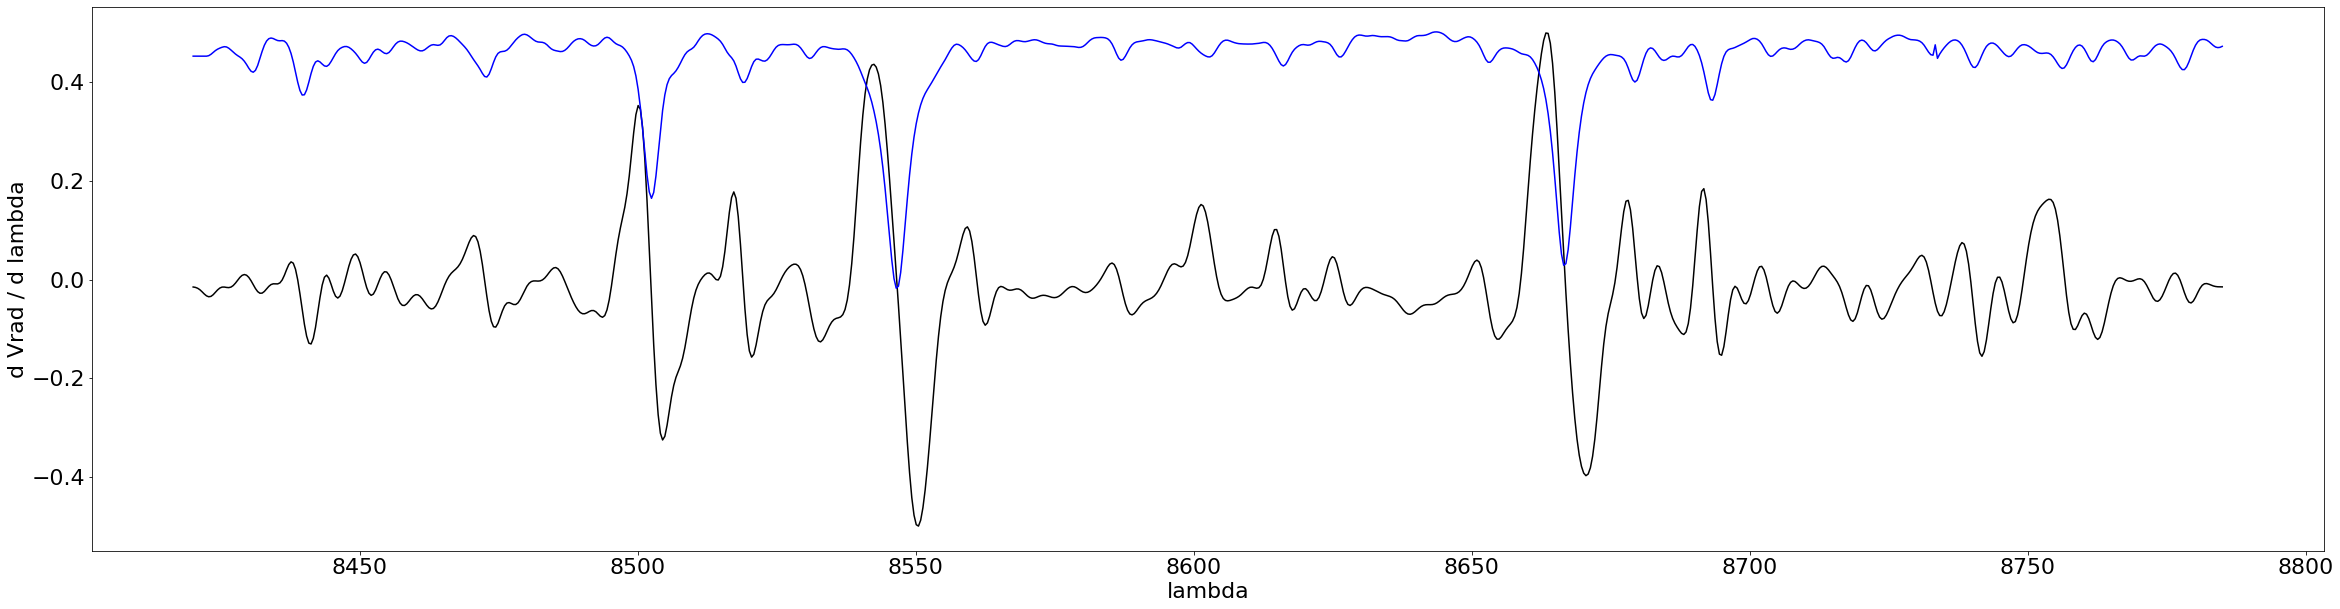

In [30]:
ytitle = ['d Vrad / d lambda']
element = ["Teff"]
wl_range = np.linspace(8420.0,8785.0,913)#[10:7191]
fig=plt.figure(figsize=(40,10))
plt.rcParams.update({'font.size': 22})

for i in range(len(element)):
    print(i)
    ax = plt.subplot(1,1,1)
    mean_grad = np.mean(final_eg_test[:,:,:,0], axis=1)[i,:]
    gradi = (mean_grad - np.min(mean_grad)) / (np.max(mean_grad) - np.min(mean_grad)) - 0.5
    ax.plot(wl_range, gradi, alpha=1.0, c='black')
    ax.plot(wl_range, np.mean(X_test_spec, axis=0) - 0.5, alpha=1.0, c='blue')

    ax.set_ylabel(ytitle[i])
    ax.set_xlabel('lambda')

plt.savefig("plots/"+run+"/gradients.png", bbox_inches='tight')
#plt.close(fig)

In [31]:
#labels  = np.array(label_names[1:])
#lim_nam = np.array(["lim_" + suit for suit in label_names[1:len(label_names)//2+1]])

#Save results from observed data
df_all = pd.DataFrame(np.hstack((final_res_obs,final_disp_of_nll_obs)), columns=["Vrad", "eVrad"])
df_all["RAVE_OBS_ID"]          = alle.RAVE_OBS_ID
df_all.to_csv("results/Vrad_v" + v + "_cnn_rave_obs_" + flag_phot + "_phot_mse_ex_filt.csv",index=False)

#Save results from Res_train
df_res_train = pd.DataFrame(np.hstack((y_train, final_res_train,final_disp_of_nll_train)), columns=["Vrad_ref", "Vrad", "eVrad"])
df_res_train["RAVE_OBS_ID"]= y_train_IDs   #cname instead of rave_obs_id ?
df_res_train.to_csv("results/Vrad_v" + v + "_cnn_rave_train_" + flag_phot + "_phot_mse_ex_filt.csv",index=False)

#Save results from Res_test
df_res_test  = pd.DataFrame(np.hstack((y_test, final_res_test, final_disp_of_nll_test)), columns=["Vrad_ref", "Vrad", "eVrad"])
df_res_test["RAVE_OBS_ID"]= y_test_IDs
df_res_test.to_csv("results/Vrad_v" + v + "_cnn_rave_test_" + flag_phot +  "_phot_mse_ex_filt.csv",index=False)


#### some plots to visualise the training and test samples

#### Training set Teff_vs_logg color coded with (Vrad_output - Vrad_input)

In [32]:
df_res_train = pd.read_csv('results/Vrad_v1_cnn_rave_train_False_phot_mse_ex_filt.csv')
df_res_test = pd.read_csv('results/Vrad_v1_cnn_rave_test_False_phot_mse_ex_filt.csv')
df_res_obs = pd.read_csv('results/Vrad_v1_cnn_rave_obs_False_phot_mse_ex_filt.csv')

In [33]:
train_params = pd.read_csv('Data/labels_large_training_sample_uncorrected_spectra_vrad_-200_200_extra_filter_with_params.csv')

In [34]:
train_params.columns

Index(['RAVE_OBS_ID', 'GAIAEDR3_SOURCE_ID', 'ruwe', 'RAVEID', 'OBJECTID',
       'HRV_SPARV', 'HRV_error_SPARV', 'CorrelationCoeff_SPARV',
       'CorrectionRV_SPARV', 'CHISQ_SPARV', 'SNR_med_SPARV', 'flag1_Class',
       'flag2_Class', 'flag3_Class', 'w1_Class', 'w2_Class', 'w3_Class',
       'W1mag_ALLWISE', 'W2mag_ALLWISE'],
      dtype='object')

In [35]:
bdasp = pd.read_csv("../RAVE/tmp/DR6_BDASP.csv")

In [36]:
bdasp.columns

Index(['RAVE_OBS_ID', 'distance_BDASP', 'distance_error_BDASP', 'age_BDASP',
       'age_error_BDASP', 'Teff_BDASP', 'Teff_error_BDASP', 'logg_BDASP',
       'logg_error_BDASP', 'mass_BDASP', 'mass_error_BDASP', 'log_A_V_BDASP',
       'log_A_V_error_BDASP', 'M_H_BDASP', 'M_H_error_BDASP', 'parallax_BDASP',
       'parallax_error_BDASP', 'dist_mod_BDASP', 'dist_mod_error_BDASP',
       'A_V_inf_prior_BDASP'],
      dtype='object')

In [37]:
train_set_params =  pd.merge(train_params, bdasp, on="RAVE_OBS_ID" )

In [38]:
train_set_with_params = pd.merge(df_res_train, train_set_params, on = 'RAVE_OBS_ID')

In [39]:
train_set_with_params.columns

Index(['Vrad_ref', 'Vrad', 'eVrad', 'RAVE_OBS_ID', 'GAIAEDR3_SOURCE_ID',
       'ruwe', 'RAVEID', 'OBJECTID', 'HRV_SPARV', 'HRV_error_SPARV',
       'CorrelationCoeff_SPARV', 'CorrectionRV_SPARV', 'CHISQ_SPARV',
       'SNR_med_SPARV', 'flag1_Class', 'flag2_Class', 'flag3_Class',
       'w1_Class', 'w2_Class', 'w3_Class', 'W1mag_ALLWISE', 'W2mag_ALLWISE',
       'distance_BDASP', 'distance_error_BDASP', 'age_BDASP',
       'age_error_BDASP', 'Teff_BDASP', 'Teff_error_BDASP', 'logg_BDASP',
       'logg_error_BDASP', 'mass_BDASP', 'mass_error_BDASP', 'log_A_V_BDASP',
       'log_A_V_error_BDASP', 'M_H_BDASP', 'M_H_error_BDASP', 'parallax_BDASP',
       'parallax_error_BDASP', 'dist_mod_BDASP', 'dist_mod_error_BDASP',
       'A_V_inf_prior_BDASP'],
      dtype='object')

In [40]:
len(train_set_with_params)

85397

In [41]:
rr = (train_set_with_params.Vrad -train_set_with_params.HRV_SPARV)

In [42]:
sel = (rr<20) & (rr>-20)

In [43]:
train_set_with_params = train_set_with_params[sel]

In [44]:
len(train_set_with_params)

85322

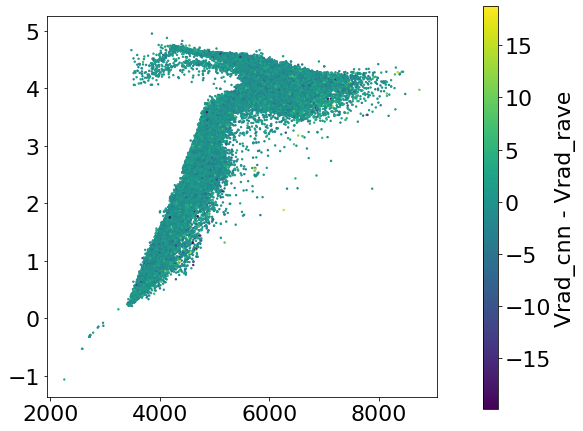

<Figure size 432x288 with 0 Axes>

In [45]:
fig = plt.figure(figsize=(7,7))
cs = plt.scatter(train_set_with_params.Teff_BDASP, train_set_with_params.logg_BDASP, c=train_set_with_params.Vrad -train_set_with_params.HRV_SPARV, s=2.0,cmap='viridis', rasterized=True)
cb_ax = fig.add_axes([0.99, 0.1, 0.03, 0.8])
cbar = fig.colorbar(cs, cax = cb_ax, label='Vrad_cnn - Vrad_rave')

#plt.title("LOGG vs TEFF")

#plt.xlim(-2,5)
#plt.ylim(2000,9000)
plt.show()
plt.savefig("plots/"+run+"/train_kiel.png", bbox_inches='tight')

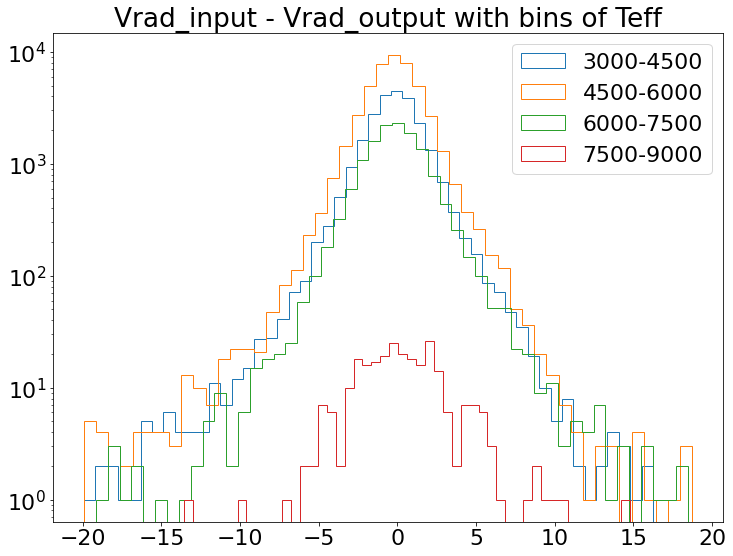

In [46]:
plt.figure(figsize=(12,9))
www = (train_set_with_params.Teff_BDASP >3000) & (train_set_with_params.Teff_BDASP <4500)
plt.hist(train_set_with_params.Vrad[www] - train_set_with_params.HRV_SPARV[www], bins=50, histtype='step', label='3000-4500', log=True);

www = (train_set_with_params.Teff_BDASP >4500) & (train_set_with_params.Teff_BDASP <6000)
plt.hist(train_set_with_params.Vrad[www] - train_set_with_params.HRV_SPARV[www], bins=50, histtype='step',label='4500-6000', log=True);

www = (train_set_with_params.Teff_BDASP >6000) & (train_set_with_params.Teff_BDASP <7500)
plt.hist(train_set_with_params.Vrad[www] - train_set_with_params.HRV_SPARV[www], bins=50, histtype='step', label='6000-7500', log=True);

www = (train_set_with_params.Teff_BDASP >7500) & (train_set_with_params.Teff_BDASP <9000)
plt.hist(train_set_with_params.Vrad[www] - train_set_with_params.HRV_SPARV[www], bins=50, histtype='step',label='7500-9000', log=True);

# www = (train_set_with_params.Teff_BDASP >7000) & (train_set_with_params.Teff_BDASP <8000)
# plt.hist(train_set_with_params.Vrad[www] - train_set_with_params.HRV_SPARV[www], bins=50, histtype='step',label='7000-8000', log=True);

plt.title('Vrad_input - Vrad_output with bins of Teff')
plt.legend()
plt.savefig("plots/"+run+"/train_vrad_in_out_teff.png", bbox_inches='tight')

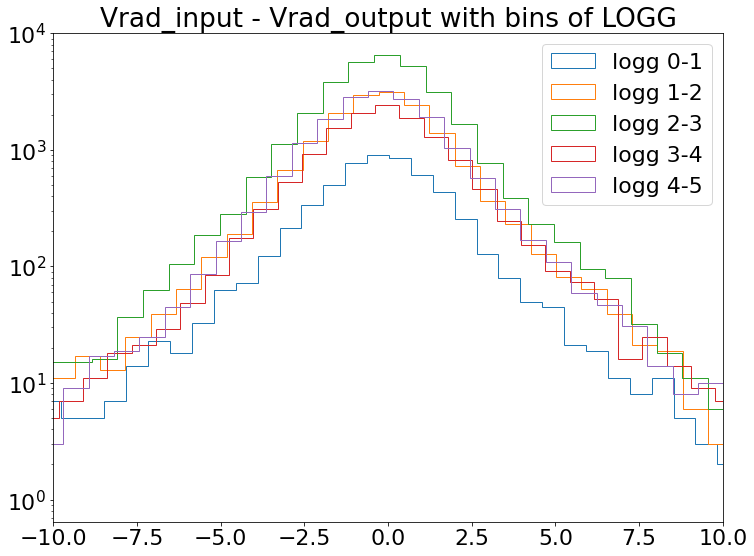

In [47]:
plt.figure(figsize = (12,9))

www = (train_set_with_params.logg_BDASP >0) & (train_set_with_params.logg_BDASP <1)
plt.hist(train_set_with_params.Vrad[www] - train_set_with_params.HRV_SPARV[www], bins=50, histtype='step', label='logg 0-1', log=True);

www = (train_set_with_params.logg_BDASP >1) & (train_set_with_params.logg_BDASP <2)
plt.hist(train_set_with_params.Vrad[www] - train_set_with_params.HRV_SPARV[www], bins=50, histtype='step',label='logg 1-2', log=True);

www = (train_set_with_params.logg_BDASP >2) & (train_set_with_params.logg_BDASP <3)
plt.hist(train_set_with_params.Vrad[www] - train_set_with_params.HRV_SPARV[www], bins=50, histtype='step', label='logg 2-3', log=True);

www = (train_set_with_params.logg_BDASP >3) & (train_set_with_params.logg_BDASP <4)
plt.hist(train_set_with_params.Vrad[www] - train_set_with_params.HRV_SPARV[www], bins=50, histtype='step', label='logg 3-4', log=True);

www = (train_set_with_params.logg_BDASP >4) & (train_set_with_params.logg_BDASP <5)
plt.hist(train_set_with_params.Vrad[www] - train_set_with_params.HRV_SPARV[www], bins=50, histtype='step', label='logg 4-5', log=True);

plt.title('Vrad_input - Vrad_output with bins of LOGG')
plt.legend()
plt.xlim(-10,10)
plt.savefig("plots/"+run+"/train_vrad_in_out_logg.png", bbox_inches='tight')

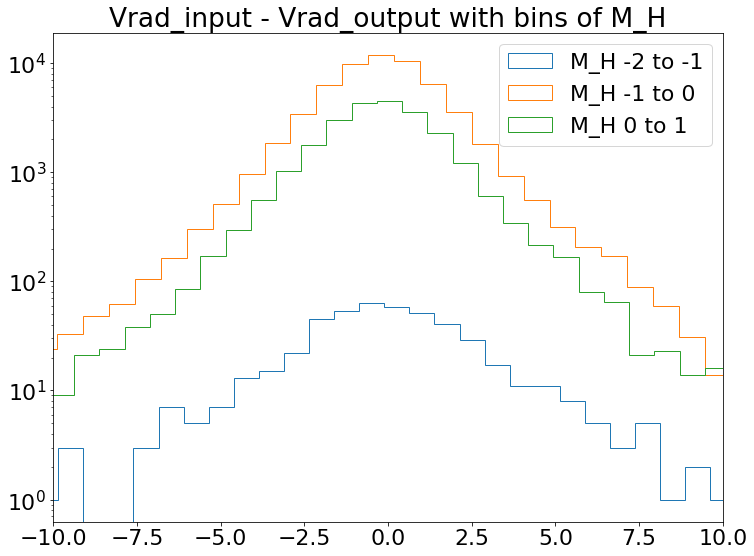

In [48]:
plt.figure(figsize=(12,9))

www = (train_set_with_params.M_H_BDASP >-2.0) & (train_set_with_params.M_H_BDASP<-1)
plt.hist(train_set_with_params.Vrad[www] - train_set_with_params.HRV_SPARV[www], bins=50, histtype='step', label = 'M_H -2 to -1', log=True);

www = (train_set_with_params.M_H_BDASP >-1.0) & (train_set_with_params.M_H_BDASP<0)
plt.hist(train_set_with_params.Vrad[www] - train_set_with_params.HRV_SPARV[www], bins=50, histtype='step', label = 'M_H -1 to 0', log=True);

www = (train_set_with_params.M_H_BDASP >0) & (train_set_with_params.M_H_BDASP<1)
plt.hist(train_set_with_params.Vrad[www] - train_set_with_params.HRV_SPARV[www], bins=50, histtype='step', label = 'M_H 0 to 1', log=True);

plt.title('Vrad_input - Vrad_output with bins of M_H')
plt.legend()
plt.xlim(-10,10)
plt.savefig("plots/"+run+"/train_vrad_in_out_MH.png", bbox_inches='tight')

#### Test set

In [49]:
test_set_with_params = pd.merge(df_res_test, train_set_params, on="RAVE_OBS_ID")

In [50]:
tt = (test_set_with_params.Vrad -test_set_with_params.HRV_SPARV)

In [51]:
sel_t = (tt<20) & (tt>-20)

In [52]:
test_set_with_params = test_set_with_params[sel_t]

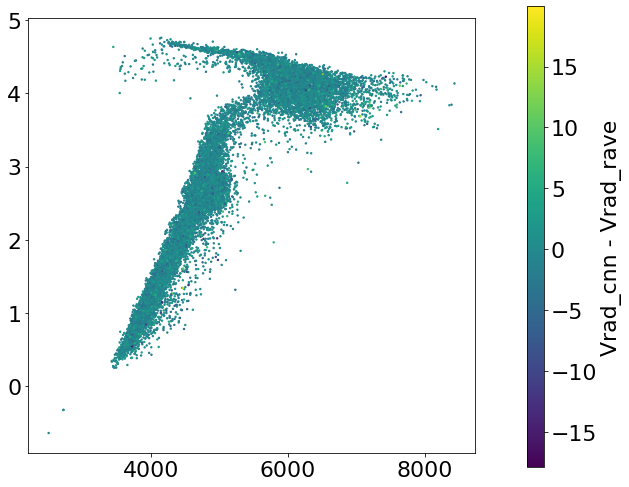

<Figure size 432x288 with 0 Axes>

In [53]:
fig = plt.figure(figsize=(8,8))
cs = plt.scatter(test_set_with_params.Teff_BDASP, test_set_with_params.logg_BDASP, c=test_set_with_params.Vrad -test_set_with_params.HRV_SPARV, s=2.0,cmap='viridis', rasterized=True)
cb_ax = fig.add_axes([0.99, 0.1, 0.03, 0.8])
cbar = fig.colorbar(cs, cax=cb_ax,label='Vrad_cnn - Vrad_rave')

#plt.xlim(-2,5)
#plt.ylim(2000,9000)
plt.show()
plt.savefig("plots/"+run+"/test_kiel.png", bbox_inches='tight')

#### Vrad_input - Vrad_output for different bins of teff, logg and M_H

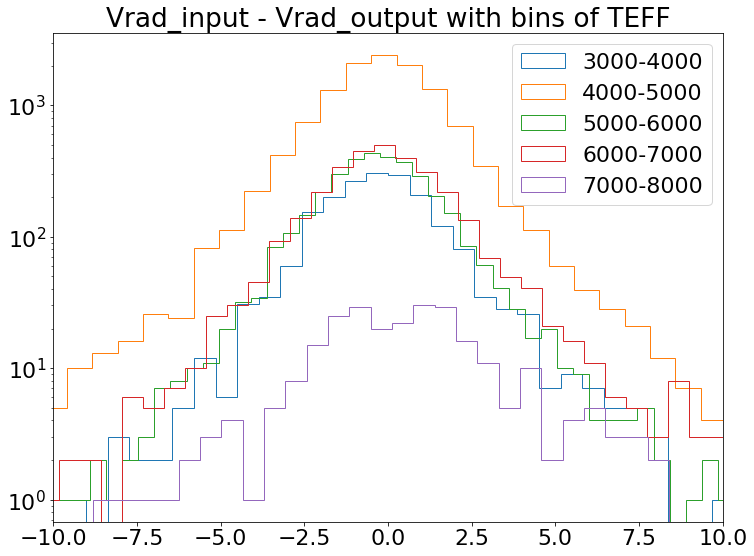

In [54]:
plt.figure(figsize=(12,9))
www = (test_set_with_params.Teff_BDASP >3000) & (test_set_with_params.Teff_BDASP <4000)
plt.hist(test_set_with_params.Vrad[www] - test_set_with_params.HRV_SPARV[www], bins=50, histtype='step', label='3000-4000', log=True);

www = (test_set_with_params.Teff_BDASP >4000) & (test_set_with_params.Teff_BDASP <5000)
plt.hist(test_set_with_params.Vrad[www] - test_set_with_params.HRV_SPARV[www], bins=50, histtype='step',label='4000-5000', log=True);

www = (test_set_with_params.Teff_BDASP >5000) & (test_set_with_params.Teff_BDASP <6000)
plt.hist(test_set_with_params.Vrad[www] - test_set_with_params.HRV_SPARV[www], bins=50, histtype='step', label='5000-6000', log=True);

www = (test_set_with_params.Teff_BDASP >6000) & (test_set_with_params.Teff_BDASP <7000)
plt.hist(test_set_with_params.Vrad[www] - test_set_with_params.HRV_SPARV[www], bins=50, histtype='step',label='6000-7000', log=True);

www = (test_set_with_params.Teff_BDASP >7000) & (test_set_with_params.Teff_BDASP <8000)
plt.hist(test_set_with_params.Vrad[www] - test_set_with_params.HRV_SPARV[www], bins=50, histtype='step',label='7000-8000', log=True);

plt.title('Vrad_input - Vrad_output with bins of TEFF')
plt.legend()
plt.xlim(-10,10)
plt.savefig("plots/"+run+"/test_vrad_in_out_teff.png", bbox_inches='tight')

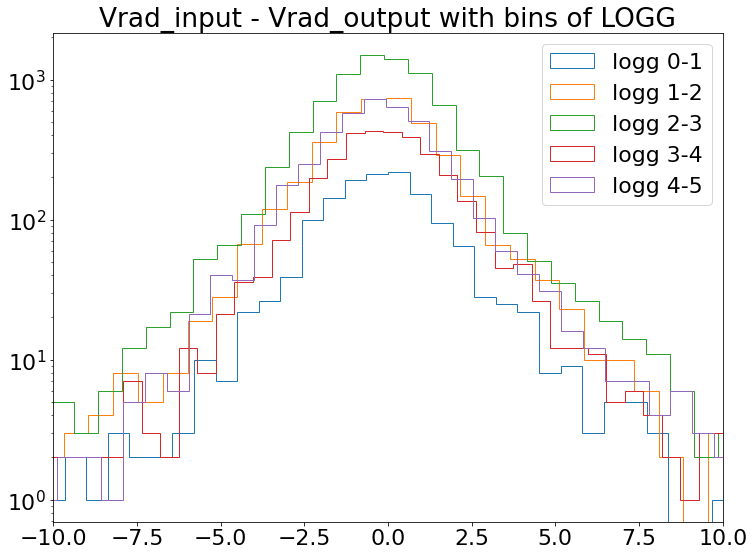

In [55]:
plt.figure(figsize = (12,9))

www = (test_set_with_params.logg_BDASP >0) & (test_set_with_params.logg_BDASP <1)
plt.hist(test_set_with_params.Vrad[www] - test_set_with_params.HRV_SPARV[www], bins=50, histtype='step', label='logg 0-1', log=True);

www = (test_set_with_params.logg_BDASP >1) & (test_set_with_params.logg_BDASP <2)
plt.hist(test_set_with_params.Vrad[www] - test_set_with_params.HRV_SPARV[www], bins=50, histtype='step',label='logg 1-2', log=True);

www = (test_set_with_params.logg_BDASP >2) & (test_set_with_params.logg_BDASP <3)
plt.hist(test_set_with_params.Vrad[www] - test_set_with_params.HRV_SPARV[www], bins=50, histtype='step', label='logg 2-3', log=True);

www = (test_set_with_params.logg_BDASP >3) & (test_set_with_params.logg_BDASP <4)
plt.hist(test_set_with_params.Vrad[www] - test_set_with_params.HRV_SPARV[www], bins=50, histtype='step', label='logg 3-4', log=True);

www = (test_set_with_params.logg_BDASP >4) & (test_set_with_params.logg_BDASP <5)
plt.hist(test_set_with_params.Vrad[www] - test_set_with_params.HRV_SPARV[www], bins=50, histtype='step', label='logg 4-5');

plt.title('Vrad_input - Vrad_output with bins of LOGG')
plt.legend()
plt.xlim(-10,10)
plt.savefig("plots/"+run+"/test_vrad_in_out_logg.png", bbox_inches='tight')

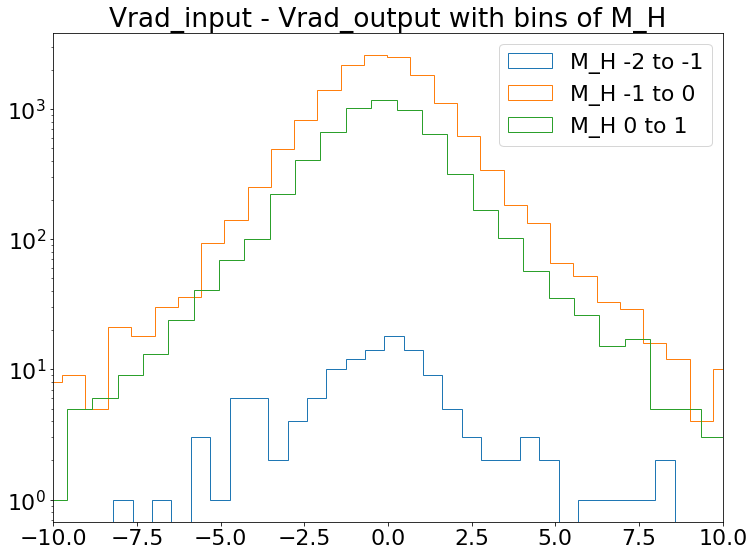

In [56]:
plt.figure(figsize=(12,9))

www = (test_set_with_params.M_H_BDASP >-2.0) & (test_set_with_params.M_H_BDASP<-1)
plt.hist(test_set_with_params.Vrad[www] - test_set_with_params.HRV_SPARV[www], bins=50, histtype='step', label = 'M_H -2 to -1', log=True);

www = (test_set_with_params.M_H_BDASP >-1.0) & (test_set_with_params.M_H_BDASP<0)
plt.hist(test_set_with_params.Vrad[www] - test_set_with_params.HRV_SPARV[www], bins=50, histtype='step', label = 'M_H -1 to 0', log=True);

www = (test_set_with_params.M_H_BDASP >0) & (test_set_with_params.M_H_BDASP<1)
plt.hist(test_set_with_params.Vrad[www] - test_set_with_params.HRV_SPARV[www], bins=50, histtype='step', label = 'M_H 0 to 1', log=True);

plt.title('Vrad_input - Vrad_output with bins of M_H')
plt.legend()
plt.xlim(-10,10)
plt.savefig("plots/"+run+"/test_vrad_in_out_MH.png", bbox_inches='tight')